In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the dataset
data = pd.read_csv('ex1.csv')
data.head(3)

,pair,mins,price,entry,exit value
0,A,5,100,0,0
1,A,10,200,1,NaN
2,A,15,300,0,0


# Data Split

In [3]:
# Split the data
X = data.drop(['entry','pair', 'exit value'], axis=1)
y= data['entry']

# run stratified split (random by default)
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.5 , stratify= data['pair'] )

"""
# run non-random split (test set is the last few rows of data)
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2 , shuffle = False)

"""

'\n# run non-random split (test set is the last few rows of data)\nX_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2 , shuffle = False)\n\n'

### 1. Fit the model

In [5]:
# fit the model
clas = RandomForestClassifier(n_estimators = 100, criterion = 'entropy',random_state= 25, n_jobs=-1)
clas.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)

### 2. Assess model performance

Accuracy: 0.907
Null Accuracy: 0    0.697674
Name: entry, dtype: float64
k-fold Accuracies mean: 0.917
k-fold Accuracies std: 0.074
_______________________________________________


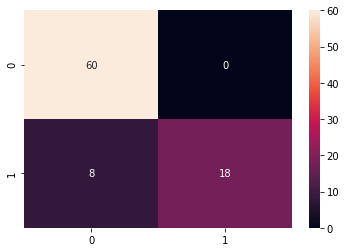

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        60
           1       1.00      0.69      0.82        26

    accuracy                           0.91        86
   macro avg       0.94      0.85      0.88        86
weighted avg       0.92      0.91      0.90        86

__________________________
Feature Importance

       importance
mins     0.561084
price    0.438916
__________________________


In [6]:
# get model predictions
y_pred = clas.predict(X_test)

# 1. Accuracy Score 
print(f'Accuracy: {round(clas.score(X_test, y_test), 3)}')
print(f'Null Accuracy: { y_test.value_counts().head(1)/ len(y_test)}')

# 2. K-Fold cross validation
accuracies = cross_val_score(estimator = clas, X = X_train, y = y_train, cv = 10, n_jobs= -1 )
print(f'k-fold Accuracies mean: {round(accuracies.mean(), 3)}')
print(f'k-fold Accuracies std: {round(accuracies.std(), 3)}')
print('_______________________________________________')

# 3. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.ylim(2,0)
plt.show()

# 4. Summary report
print(classification_report(y_test, y_pred))


# 5. Feature Importance
print('__________________________')
print('Feature Importance')
print()
print(pd.DataFrame(clas.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False) )
print('__________________________')


### 3. Apply GridSearchCV to fine-tune hyperparameters

In [7]:
# set the parameters to test
parameters = [{'n_estimators' : [30, 50, 100], 'criterion': ['entropy']},
              {'n_estimators' : [30, 50, 100], 'criterion': ['gini']}
             ]

# set GridSearchCV
grid_search = GridSearchCV(estimator = clas,
                          param_grid = parameters,
                          scoring = 'accuracy',
                          cv = 10,
                          n_jobs = -1)

# fit 
grid_search = grid_search.fit(X_train, y_train)

# get best accuracy and parameters
print(f'Best Accuracy: {round(grid_search.best_score_, 5)}')
print(f'Best Parameters: {grid_search.best_params_}')

cv_results = (pd.DataFrame( grid_search.cv_results_ ))
pd.options.display.max_colwidth = 100
cv_results['min_pred_mean']= cv_results['mean_test_score']- (3 * cv_results['std_test_score'])
cv_results[['params', 'mean_test_score', 'std_test_score',
            'rank_test_score','min_pred_mean']].sort_values(by ='min_pred_mean',ascending=False).head(5)

Best Accuracy: 0.91765
Best Parameters: {'criterion': 'entropy', 'n_estimators': 30}


,params,mean_test_score,std_test_score,rank_test_score,min_pred_mean
0,"{'criterion': 'entropy', 'n_estimators': 30}",0.917647,0.075075,1,0.692421
1,"{'criterion': 'entropy', 'n_estimators': 50}",0.917647,0.075075,1,0.692421
2,"{'criterion': 'entropy', 'n_estimators': 100}",0.917647,0.075075,1,0.692421
3,"{'criterion': 'gini', 'n_estimators': 30}",0.917647,0.075075,1,0.692421
4,"{'criterion': 'gini', 'n_estimators': 50}",0.917647,0.075075,1,0.692421
